In [1]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import scipy.sparse as sp
from scipy.stats import binned_statistic
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
ddf_data = np.load('ddf_grid.npz')
ddf_grid = ddf_data['ddf_grid'].copy()

# XXX-- double check that I got this right
ack = ddf_grid['sun_alt'][0:-1] * ddf_grid['sun_alt'][1:]
night = np.zeros(ddf_grid.size, dtype=int)
night[np.where((ddf_grid['sun_alt'][1:] >=0) & (ack < 0))] += 1
night = np.cumsum(night)

In [3]:
ddf_grid

array([(59853.5       ,  0.35789797, 0.        ,         nan,         nan,  0.        , nan, nan,  0.        ,  0., inf,  0.        ,  0., inf,  0.        ,  0., inf),
       (59853.51041667,  0.41360456, 0.        ,         nan,         nan,  0.        , nan, nan,  0.        ,  0., inf,  0.        ,  0., inf,  0.        ,  0., inf),
       (59853.52083333,  0.46894875, 0.        ,         nan,         nan,  0.        , nan, nan,  0.        ,  0., inf,  0.        ,  0., inf,  0.        ,  0., inf),
       ...,
       (63505.96874915, -0.12942338, 0.        ,  0.        ,         inf, -0.        , nan, nan, -0.        , nan, nan, -0.        , nan, nan, -0.        , nan, nan),
       (63505.97916582, -0.18569237, 0.        ,  0.        ,         inf, -0.        , nan, nan, -0.        , nan, nan, -0.        , nan, nan, -0.        , nan, nan),
       (63505.98958248, -0.24112162, 1.90646443, 20.87839022, 23.56106875, -9.35888477, nan, nan, -8.85712875, nan, nan, -1.36598529, nan, nan, -1.4

In [4]:
# check what the timestep is
24*60*(ddf_grid['mjd'][1] - ddf_grid['mjd'][0])

14.99999999650754

In [5]:
m = gp.Model("try_sched")

Academic license - for non-commercial use only - expires 2021-06-18
Using license file /Users/yoachim/Dropbox/Apps/Gurobi/gurobi.lic


In [6]:
ngrid = ddf_grid['mjd'].size
sun_limit = np.radians(-18.)
airmass_limit = 2.1  
sky_limit = 22. #20. #21.5 #22.
zeropoint = 25.0  # mags
sequence_limit = 400 #230
pause_time = 13/24.  # days
delta_t = ddf_grid['mjd'][1] - ddf_grid['mjd'][0]

# Let's try scheduling just one for now
schedule = m.addMVar(ngrid, vtype=GRB.BINARY, name="pointing_1")

# set a sun mask
sun_mask = np.zeros(ngrid, dtype=bool)
sun_mask[np.where(ddf_grid['sun_alt'] >= sun_limit)] = 1

airmass_mask = np.zeros(ngrid, dtype=bool)
airmass_mask[np.where(ddf_grid['DD:ELAISS1_airmass'] >= airmass_limit)] = 1

sky_mask = np.zeros(ngrid, dtype=bool)
sky_mask[np.where(ddf_grid['DD:ELAISS1_sky_g'] <= sky_limit)] = 1
sky_mask[np.where(np.isnan(ddf_grid['DD:ELAISS1_sky_g']) == True)] = 1

# Let's add the constraints
m.addConstr(schedule @ sun_mask == 0)
m.addConstr(schedule @ airmass_mask == 0)
m.addConstr(schedule @ sky_mask == 0)

# limit the total number of ddf sequences
# HA! Need to set an exact number I think. Or maybe a range.
m.addConstr(schedule.sum() == sequence_limit)


# prevent a repeat sequence in a night
unights = np.unique(night)
sched_night = m.addMVar(unights.size, vtype=GRB.CONTINUOUS)
for i,n in enumerate(unights):
    in_night = np.where(night == n)[0]
    m.addConstr(schedule[in_night]@schedule[in_night] <= 1)
    m.addConstr(sched_night[i] == schedule[in_night].sum())

In [7]:
blank = np.ones(ngrid, dtype=int)
blank[np.where(sky_mask == 1)] = 0
blank[np.where(airmass_mask == 1)] = 0
blank[np.where(sun_mask == 1)] = 0
bins = np.arange(np.min(night)-0.5, np.max(night)+1.5)
slots_per_night, _be, _bn = binned_statistic(night, blank, statistic=np.sum, bins=bins)

# Let's modify so it's equal weight any place there are more than N slots in a night
slot_limit = 1
slots_per_night[np.where(slots_per_night < slot_limit)] = 0
slots_per_night[np.where(slots_per_night >= slot_limit)] = 1


# ok, let's forbid 4 day gaps:
# that was fun, splits the median peak at 4 into 3 and 5.
#m.addConstr(sched_night[:-4]@sched_night[4:] == 0)


In [8]:
#slots_per_night
cumulative_desired = np.cumsum(slots_per_night)
cumulative_desired = cumulative_desired/cumulative_desired.max()*sequence_limit
# what happens if I put a floor on this to make my desired one discrete?
# Makes it go blazing fast agian, that's for sure!
# cumulative_desired = np.round(cumulative_desired)

In [9]:
# Let's compute the potential energy of the distribution and minimize that
position = np.arange(unights.size)
# Here's an objective that works
#obj = sched_night[:-1]@sched_night[1:] + sched_night[:-2]@sched_night[2:]*0.5 + sched_night[:-3]@sched_night[3:]*(1./3)
obj = sched_night[:-1]@sched_night[1:]
for i in range(2,5):
    obj += sched_night[:-i]@sched_night[i:]*(1./i)


# Compute t_eff, something we want to maximize
t_eff = 10.**(.08*(ddf_grid['DD:ELAISS1_m5_g']-zeropoint))
t_eff[np.where(np.isnan(t_eff) == True)] = 0
t_eff[np.where(np.isinf(t_eff) == True)] = 0


In [10]:

# Cumulative number of scheduled events (by night, to avoid huge loop)
cumulative_sched = m.addMVar(unights.size, vtype=GRB.CONTINUOUS)
cumulative_diff = m.addMVar(unights.size, vtype=GRB.CONTINUOUS, lb=-sequence_limit, ub=sequence_limit)

cumulative_dmax = m.addMVar(unights.size, vtype=GRB.CONTINUOUS)


m.addConstr(cumulative_sched[0] == sched_night[0])

#linear_cumulative = np.arange(unights.size)
#linear_cumulative = linear_cumulative/np.max(linear_cumulative) * sequence_limit
#m.addConstr(cumulative_diff[0] == cumulative_sched[0] - linear_cumulative[0])
m.addConstr(cumulative_diff[0] == cumulative_sched[0] - cumulative_desired[0])


for i in np.arange(1,unights.size):
    m.addConstr(cumulative_sched[i] == cumulative_sched[i-1]+sched_night[i])
    m.addConstr(cumulative_diff[i] == cumulative_sched[i] - cumulative_desired[i])
    

(21.0, 23.0)

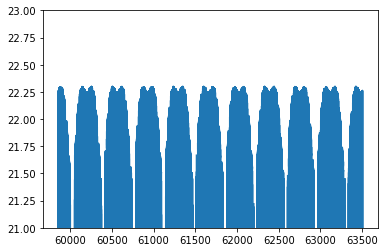

In [11]:
plt.plot(ddf_grid['mjd'], ddf_grid['DD:ELAISS1_sky_g'])
plt.ylim([21,23])

In [12]:
# maximize the t_eff
#m.setObjective(t_eff@schedule, GRB.MAXIMIZE)
# minimize the potential energy
#m.setObjective(obj, GRB.MINIMIZE)
# Try to match a CDF
m.setObjective(cumulative_diff@cumulative_diff, GRB.MINIMIZE)

In [13]:
m.Params.TimeLimit = 200
m.optimize()

Changed value of parameter TimeLimit to 200.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10963 rows, 365252 columns and 1302550 nonzeros
Model fingerprint: 0x6f3424bf
Model has 3653 quadratic objective terms
Model has 3653 quadratic constraints
Variable types: 14612 continuous, 350640 integer (350640 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+00]
  Bounds range     [1e+00, 4e+02]
  RHS range        [1e+00, 4e+02]
  QRHS range       [1e+00, 1e+00]
Presolve removed 6868 rows and 359508 columns
Presolve time: 0.59s
Presolved: 4095 rows, 5744 columns, 13076 nonzeros
Presolved model has 3652 quadratic objective terms
Variable types: 0 continuous, 5744 integer (1650 binary)

Root relaxation: objective 0.000000e+00, 131

In [14]:
result_array = schedule.X

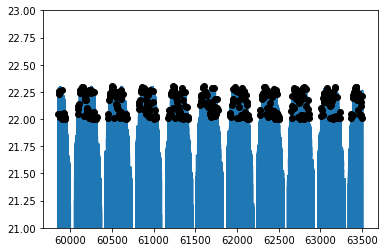

In [15]:
plt.plot(ddf_grid['mjd'], ddf_grid['DD:ELAISS1_sky_g'])
plt.ylim([21,23])
sched = np.where(result_array > 0)[0]
plt.plot(ddf_grid['mjd'][sched], ddf_grid['DD:ELAISS1_sky_g'][sched], 'ko')

(60000.0, 60500.0)

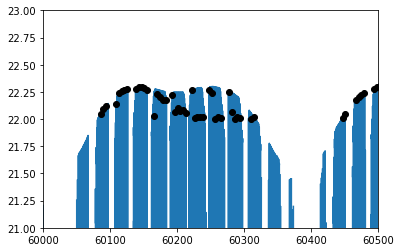

In [16]:
plt.plot(ddf_grid['mjd'], ddf_grid['DD:ELAISS1_sky_g'])
plt.ylim([21,23])
sched = np.where(result_array > 0)[0]
plt.plot(ddf_grid['mjd'][sched], ddf_grid['DD:ELAISS1_sky_g'][sched], 'ko')
plt.xlim(60000, 60500)

In [17]:
np.where( (ddf_grid['mjd'][sched] > 60300) & (ddf_grid['mjd'][sched] < 60400))

(array([55, 56]),)

In [18]:

#ack = ddf_grid['DD:ELAISS1_airmass'][np.where((ddf_grid['mjd'] > 60300) & (ddf_grid['mjd'] < 60400))]
#ack[np.where((ack > 1) & (ack < 2.5))]

(60050.0, 60200.0)

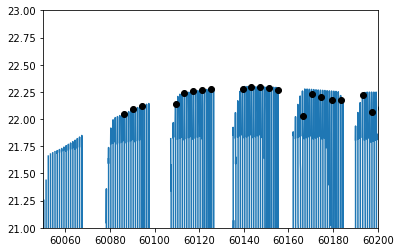

In [19]:
plt.plot(ddf_grid['mjd'], ddf_grid['DD:ELAISS1_sky_g'])
plt.ylim([21,23])
sched = np.where(result_array > 0)[0]
plt.plot(ddf_grid['mjd'][sched], ddf_grid['DD:ELAISS1_sky_g'][sched], 'ko')
plt.xlim(60050, 60200)

(60120.0, 60160.0)

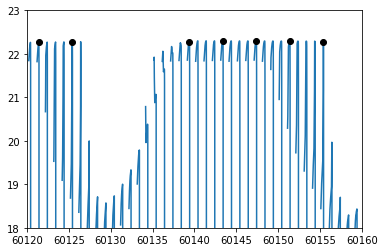

In [20]:
plt.plot(ddf_grid['mjd'], ddf_grid['DD:ELAISS1_sky_g'])
plt.ylim([18,23])
sched = np.where(result_array > 0)[0]
plt.plot(ddf_grid['mjd'][sched], ddf_grid['DD:ELAISS1_sky_g'][sched], 'ko')
plt.xlim(60120, 60160)

In [21]:
# can try to also optimize uniformity! Could use the KS statistic. 

# Good answer on how to do a cumulative sum here:  https://stackoverflow.com/questions/55840816/gurobi-prefix-sum-optimization

In [22]:
#m.setObjective(gp.max_(cumulative_diff), GRB.MINIMIZE)

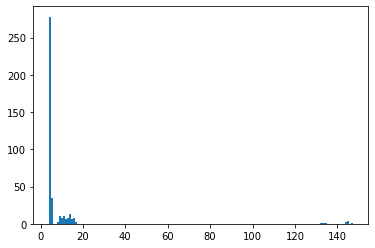

In [23]:
ack = plt.hist(np.diff(ddf_grid['mjd'][sched]), bins=150)

In [24]:
np.median(np.diff(ddf_grid['mjd'][sched]))

4.0312499990614015

In [25]:
cumulative_diff.X.min()

-0.0

In [26]:
cumulative_diff.X.max()

-0.0

In [27]:
cumulative_diff.X

array([-0., -0.,  0., ...,  0.,  0.,  0.])

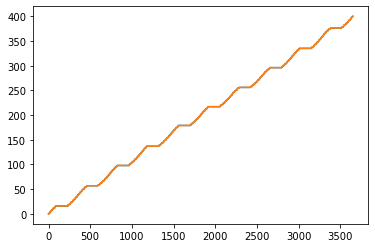

In [28]:
plt.plot(cumulative_sched.X)
plt.plot(cumulative_desired)

(0.0, 50.0)

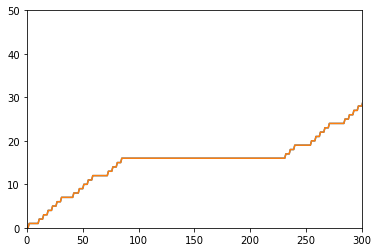

In [31]:
plt.plot(cumulative_sched.X)
plt.plot(cumulative_desired)
plt.xlim([0,300])
plt.ylim(0,50)

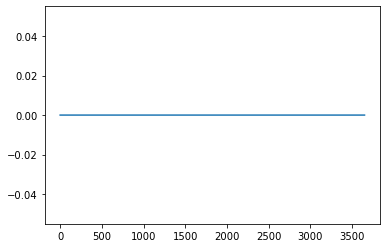

In [29]:
plt.plot(cumulative_diff.X)

# I can have an objective function that works for effective exposure time. I have an objective function that maximizes potential energy of the distribution. I can't have too many terms in that one though, or it slows down. Maybe I need an objective that tries to make the distribution match a uniform CDF? Or I could bin down into blocks of 10 nights, and then do the potential between those. Kind of a tree-sph thing.

# Next steps

* try running with the t_eff max at the same time
* try scheduling 2 DDFs at the same time
* try different possible CDFs (rolling and acourdian) 
* Need to make the CDF not go flat over lunar breaks to force it to cover the gaps better